Libraries importation

In [5]:
import os
import kagglehub
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

Data loading : NQ

In [38]:
path = kagglehub.dataset_download("novandraanugrah/nasdaq-100-nas100-historical-price-data")

print("Available file :", os.listdir(path))

file_path = os.path.join(path, "1m_data.csv")
df = pd.read_csv(file_path, sep='\t')
print(df.head())

Available file : ['15m_data.csv', '1d_data.csv', '1h_data.csv', '1Month_data.csv', '1m_data.csv', '1w_data.csv', '30m_data.csv', '4h_data.csv', '5m_data.csv']
              DateTime     Open     High      Low    Close  Volume  TickVolume
0  2025.10.01 07:12:00  24584.9  24586.5  24584.5  24585.7       0          60
1  2025.10.01 07:11:00  24587.7  24587.7  24584.7  24585.0       0          50
2  2025.10.01 07:10:00  24588.0  24589.7  24587.4  24587.5       0          74
3  2025.10.01 07:09:00  24585.0  24588.5  24584.9  24587.5       0          87
4  2025.10.01 07:08:00  24582.9  24586.9  24582.9  24584.9       0          58


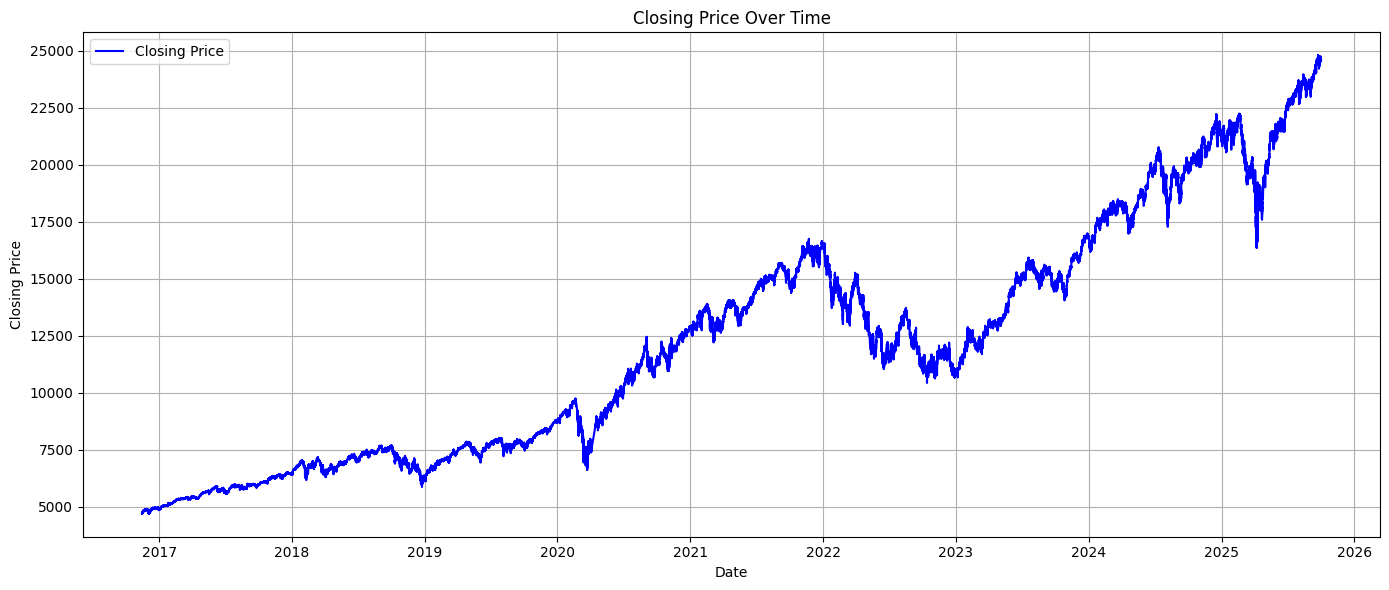

In [39]:
df['DateTime'] = pd.to_datetime(df['DateTime'])
df.rename(columns={'DateTime': 'datetime', 'Open' : "open", "High" : 'high', 'Low' : 'low', 'Close' : 'close', 'Volume' : 'volume', 'TickVolume': 'tickvolume'}, inplace=True)
df = df.sort_values('datetime')

plt.figure(figsize=(14,6))
plt.plot(df['datetime'], df['close'], label='Closing Price', color='blue')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.title('Closing Price Over Time')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


C:\Users\Emile\AppData\Local\Temp\ipykernel_17064\3925880416.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_us['session_date'] = df_us.index.date


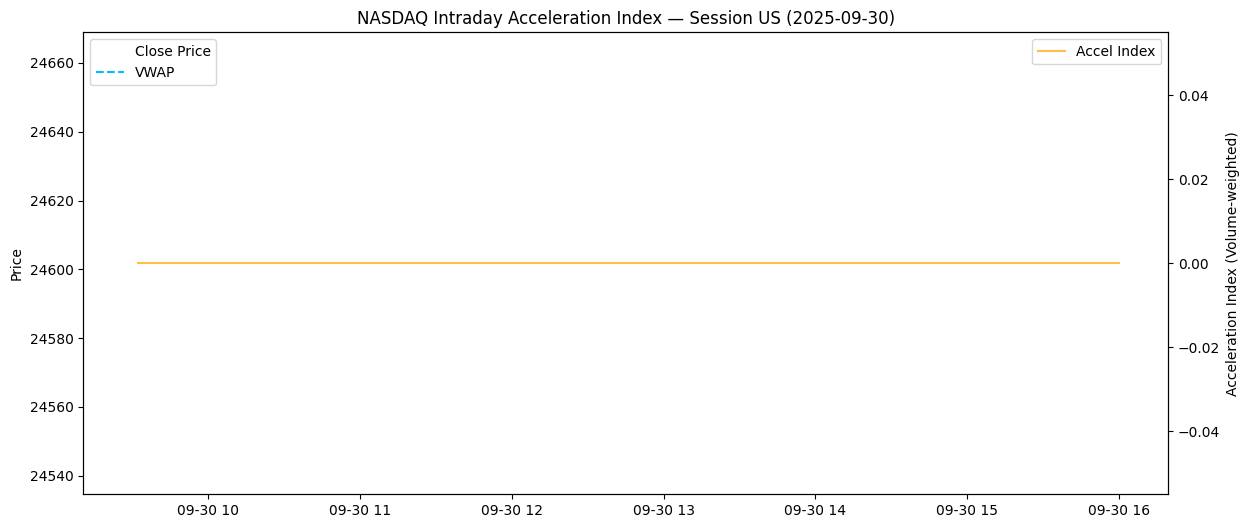

In [40]:
# param
US_OPEN = "09:30"
US_CLOSE = "16:00"
WINDOW = 30  # minutes pour le smoothing

df = df.tz_localize('UTC').tz_convert('America/New_York')

df_us = df.between_time(US_OPEN, US_CLOSE)

df_us['session_date'] = df_us.index.date

# features engineering
results = []

for date, session in df_us.groupby('session_date'):
    session = session.copy()

    # VWAP intraday (reset à chaque session)
    session['vwap'] = (session['close'] * session['volume']).cumsum() / session['volume'].cumsum()

    # VWAP high / low (rolling moyenne autour du VWAP)
    session['vwap_high'] = (
        session.assign(mask=(session['close'] > session['vwap']))
        .groupby('mask')['close']
        .transform(lambda s: s.rolling(WINDOW, min_periods=1).mean())
    )
    session['vwap_low'] = (
        session.assign(mask=(session['close'] < session['vwap']))
        .groupby('mask')['close']
        .transform(lambda s: s.rolling(WINDOW, min_periods=1).mean())
    )

    # Spread + dérivées
    session['spread'] = (session['vwap_high'] - session['vwap_low']).ffill().bfill()
    session['spread_vel'] = session['spread'].diff()
    session['spread_accel'] = session['spread_vel'].diff()

    # Lissage
    session['spread_accel_smooth'] = session['spread_accel'].ewm(span=10, adjust=False).mean()

    # Indice d’accélération pondéré par le volume
    session['accel_index'] = session['spread_accel_smooth'] * np.log1p(session['volume'])

    results.append(session)

df_sessions = pd.concat(results)

# --- 4. Visualisation d'une session ---
session_to_plot = df_sessions.groupby('session_date').get_group(sorted(df_sessions['session_date'].unique())[-1])

fig, ax1 = plt.subplots(figsize=(14, 6))
ax2 = ax1.twinx()

ax1.plot(session_to_plot.index, session_to_plot['close'], label='Close Price', color='white', alpha=0.8)
ax1.plot(session_to_plot.index, session_to_plot['vwap'], label='VWAP', color='deepskyblue', linestyle='--')
ax2.plot(session_to_plot.index, session_to_plot['accel_index'], label='Accel Index', color='orange', alpha=0.7)

ax1.set_title(f"NASDAQ Intraday Acceleration Index — Session US ({session_to_plot['session_date'].iloc[0]})")
ax1.set_ylabel("Price")
ax2.set_ylabel("Acceleration Index (Volume-weighted)")

ax1.legend(loc='upper left')
ax2.legend(loc='upper right')
plt.show()
